In [1]:
from __future__ import annotations

import pathlib

import polars
import seaborn
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

In [2]:
def load_data(directory: pathlib.Path) -> polars.DataFrame:
    dfs = []
    for run in directory.glob('**/results.csv'):
        try:
            df = polars.read_csv(run)
            if len(df) > 0:
                dfs.append(df)
        except Exception as e:
            print(f'Error loading {run}... skipping: {e}')
    return polars.concat(dfs)

In [3]:
data = load_data(pathlib.Path('../runs-prod/memory-overhead-v2/'))

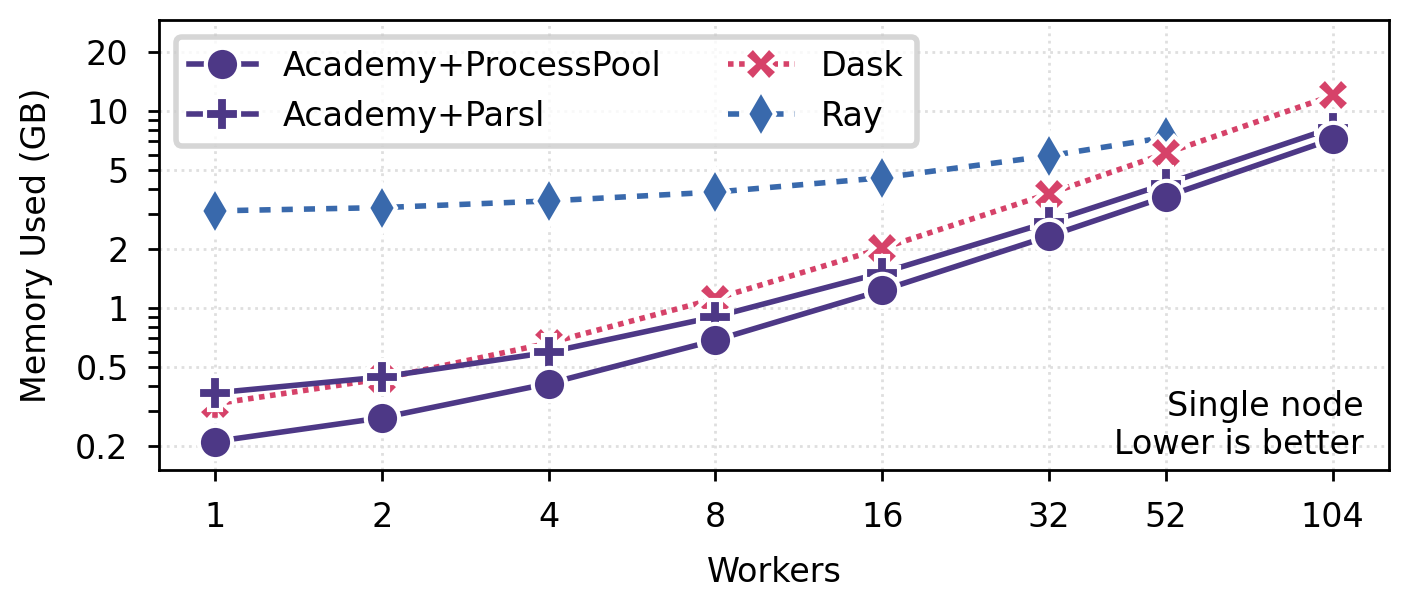

In [4]:
fig, axs = plt.subplots(1, 1)

results = data.with_columns(
    (polars.col('memory_used') / int(1e9)).alias('memory_gb'),
    polars.col('framework')
    .replace('AERIS+ParslPoolExecutor', 'AERIS+Parsl')
    .replace('AERIS+ProcessPoolExecutor', 'AERIS+ProcessPool')
    .alias('framework'),
)

xticks = sorted(set(results['active_actors'].to_list()))
yticks = [0.2, 0.5, 1, 2, 5, 10, 20]

dashes = {
    'Ray': (2, 2),
    'Dask': (1, 1),
    'AERIS+Parsl': (),
    'AERIS+ProcessPool': (),
}
markers = {
    'Ray': 'd',
    'Dask': 'X',
    'AERIS+Parsl': 'P',
    'AERIS+ProcessPool': 'o',
}
palette = {
    'Ray': '#3969AC',
    'Dask': '#D64269',
    'AERIS+Parsl': '#4D3886',
    'AERIS+ProcessPool': '#4D3886',
}

handle = seaborn.lineplot(
    results,
    x='active_actors',
    y='memory_gb',
    hue='framework',
    hue_order=['Ray', 'Dask', 'AERIS+Parsl', 'AERIS+ProcessPool'],
    errorbar=lambda x: (min(x), max(x)),
    err_style='bars',
    style='framework',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs,
)
handles, _ = axs.get_legend_handles_labels()
axs.legend(
    loc='upper left',
    ncols=2,
    handles=handles[::-1],
    title=None,
    labels=['Academy+ProcessPool', 'Academy+Parsl', 'Dask', 'Ray'],
)
_ = handle.set(
    xscale='log',
    yscale='log',
    xlabel='Workers',
    ylabel='Memory Used (GB)',
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels([str(x) for x in xticks])
handle.set_yticks(yticks, minor=False)
handle.set_yticklabels([str(y) for y in yticks])
axs.tick_params(axis='x', which='minor', bottom=False)
axs.tick_params(axis='y', which='minor', bottom=False)
axs.set(ylim=[0.15, 29])

axs.annotate(
    'Single node\nLower is better',
    xy=(0.98, 0.02),
    xycoords=('axes fraction'),
    ha='right',
    va='bottom',
)

fig.tight_layout()
plt.draw()
fig.set_size_inches(3.35, 1.25)
fig.savefig('figures/actor-memory-overhead.pdf')